# Synthesis constraining only the power spectrum

Created by Louise 23/10/2023

The goal is to find a way to stop oscillations in the synthetized power spectrum. 

In [1]:
%matplotlib notebook

# Specify CUDA device
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = 'gpu'

from jax import jit, config, grad
config.update("jax_enable_x64", True)

# Check we're running on GPU
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import time
import numpy as np
import jax.numpy as jnp
import optax
import jaxopt

from matplotlib import pyplot as plt
from importlib import reload

import scatcovjax.Sphere_lib as sphlib
import scatcovjax.Synthesis_lib as synlib
import scatcovjax.Fast_scattering_lib as scatlib
#import scatcovjax.Scattering_lib as scatlib
from s2wav.filter_factory.filters import filters_directional_vectorised

import s2fft
import s2wav

import scatcovjax.plotting as plot
plot.notebook_plot_format()

gpu


In [2]:
sampling = "mw"
multiresolution = True
reality = True

L = 256
N = 1
J_min = 2

J_max = s2wav.utils.shapes.j_max(L)
J = J_max - J_min + 1
print(f'{J=} {J_max=}')

J=7 J_max=8


# Filters

### Filters from S2FFT

<IPython.core.display.Javascript object>


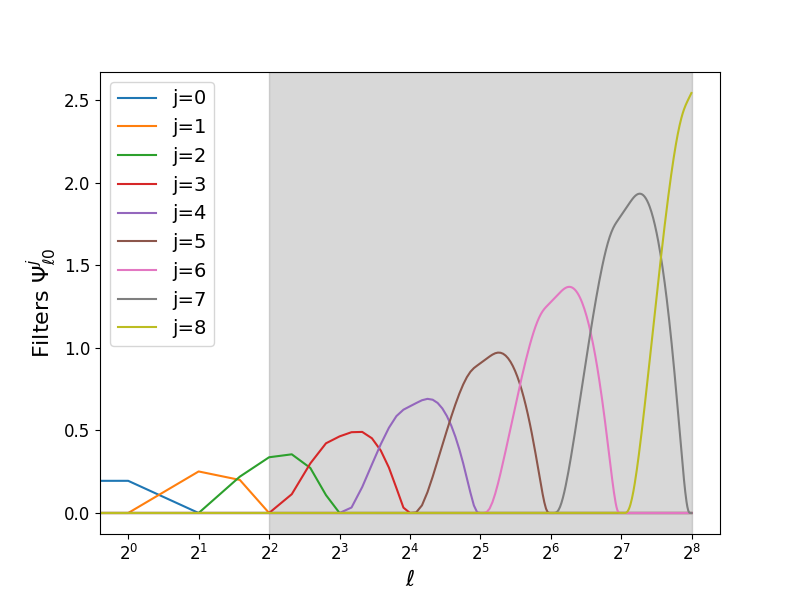

In [3]:
filters = filters_directional_vectorised(L, N, J_min)
plot.plot_filters(filters, real=True, m=L-1)
plt.axvspan(2**J_min, 2**J_max, color='grey', alpha=0.3)

# Take the wavelets only, not the scaling function
filters = filters[0]  # [J, L, 2L-1]

<IPython.core.display.Javascript object>


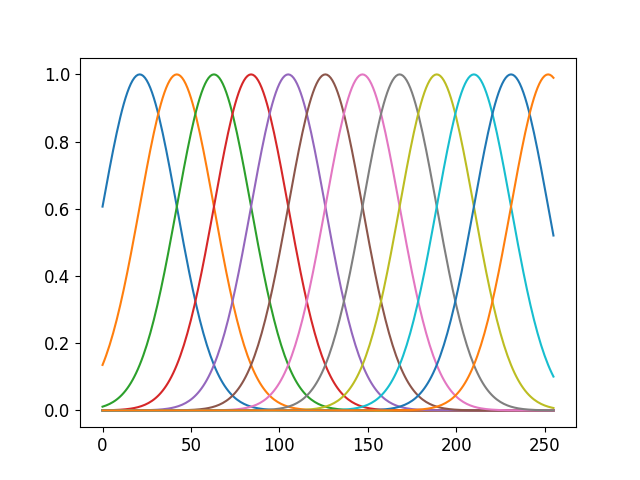

In [40]:
reload(sphlib)

Nfilters = 12
filter_lin = sphlib.make_linear_filters(Nfilters, L)

plt.figure()
ll = np.arange(L)
for j in range(Nfilters):
    plt.plot(ll, filter_lin[j, :])

# Precomputation

In [5]:
weights = scatlib.quadrature(L, J_min, sampling, None, multiresolution)

#precomps = s2wav.transforms.jax_wavelets.generate_wigner_precomputes(L, N, J_min, 2.0, sampling, None, False,
 #                                                                    reality, multiresolution)

print('\n============ Wigner precomputes ===============')
precomps = scatlib.generate_full_precompute(L=L,
                                    N=N,
                                    J_min=J_min,
                                    sampling=sampling,
                                    reality=reality,
                                    multiresolution=multiresolution,
                                    nside=None)



============ Wigner precomputes ===============


# Target

In [6]:
### Sky
repo = '/travail/lmousset/CosmoGrid/CosmoFiducial_barionified_nside512/'
f_target, flm_target = sphlib.make_CosmoGrid_sky(L, dirmap=repo, run=0, idx_z=10, sampling=sampling, 
                                   nest=False, normalize=True, reality=reality)
print('Target = LSS map')


Map at redshift z=0.14677950739860535
Mean and STD: -0.000 and 1.000
Mean and STD: 0.050 and 0.910
Target = LSS map


In [7]:
### Power spectrum of the target
ps_target = sphlib.compute_ps(flm_target)


### P00 for normalisation
tP00_norm = scatlib.get_P00only(flm_target, L, N, J_min, sampling, None,
                               reality, multiresolution, for_synthesis=False, normalisation=None,
                               filters=filters, quads=weights, precomps=precomps)  # [J][Norient]

### Scat coeffs S1, P00, C01, C11
# P00 is one because of the normalisation
tcoeffs = scatlib.scat_cov_dir(flm_target, L, N, J_min, sampling, None,
                       reality, multiresolution, for_synthesis=True, normalisation=tP00_norm,
                       filters=filters, quads=weights, precomps=precomps)

tmean, tvar, tS1, tP00, tC01, tC11 = tcoeffs  # 1D arrays

In [8]:
print(flm_target.shape)  # [L, 2L-1] if complex map [L, L] if real
print(filter_lin.shape)  # [J, L]

(256, 256)
(12, 256)


On calcule $C_{j\ell} = \sum_m |f_{\ell m} w_\ell^j|^2$ de shape $[J, L]$

Puis on prend la moyenne sur $\ell$ pour chaque filtre $j$. On obtient $P'_{00} = <C_{j\ell}>_\ell$ de shape $[J]$.

[0.00512141 0.0051903  0.0042834  0.00352378 0.00291375 0.00244698
 0.00210973 0.00187725 0.00165948 0.00149123 0.00130058 0.00075687]


<IPython.core.display.Javascript object>


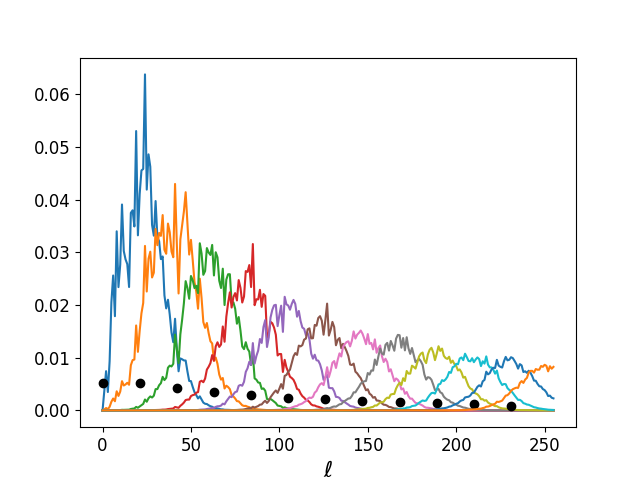

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [41]:
reload(scatlib)

# P00prime used for normalisation
tP00prime_ell, tP00prime_norm = scatlib.get_P00prime(flm_target, filter_lin, normalisation=None)
print(tP00prime_norm)

plt.figure()
for j in range(Nfilters):
    plt.plot(tP00prime_ell[j, :])
    plt.plot(L//Nfilters * j, tP00prime_norm[j], 'ko')
plt.xlabel(r'$\ell$')

# By contruction, P00' are 1 for the target
_, tP00prime = scatlib.get_P00prime(flm_target, filter_lin, normalisation=tP00prime_norm)
print(tP00prime)

# Initial conditions

In [42]:
# Gaussian white noise in pixel space with the variance of the target
print(f'{tvar=}')
np.random.seed(42)
if reality:  # Real map
    f = np.sqrt(tvar) * np.random.randn(L, 2 * L - 1).astype(np.float64)
else:
    f = np.sqrt(tvar) * np.random.randn(L, 2 * L - 1).astype(np.float64) + 1j * np.random.randn(L, 2 * L - 1).astype(np.float64)

flm = s2fft.forward_jax(f, L, reality=reality)

# Cut the flm
flm = flm[:, L - 1:] if reality else flm

flm_start = jnp.copy(flm)  # Save the start point as we will iterate on flm

tvar=Array(0.80445943+0.j, dtype=complex128)


# Gradient descent on P00

In [43]:
@jit
def loss_func_P00(flm_float):
    flm = flm_float[0, :, :] + 1j * flm_float[1, :, :]
    
    P00_new = scatlib.get_P00only(flm, L, N, J_min, sampling,
                          None, reality, multiresolution, for_synthesis=True,
                          normalisation=tP00_norm, filters=filters,
                          quads=weights, precomps=precomps)
    loss = synlib.chi2(tP00, P00_new)
    return loss

@jit
def loss_func_P00prime(flm_float):
    flm = flm_float[0, :, :] + 1j * flm_float[1, :, :]
    
    _, P00prime = scatlib.get_P00prime(flm, filter_lin, normalisation=tP00prime_norm)
    
    loss = synlib.chi2(tP00prime, P00prime)
    return loss

In [44]:
reload(scatlib)
### P00' constraint  
flm_float = jnp.array([jnp.real(flm_start), jnp.imag(flm_start)])  # [2, L, L]
flm, loss_history_P00prime = synlib.fit_jaxopt_Scipy(flm_float, loss_func_P00prime, method='L-BFGS-B', 
                                                     niter=100, loss_history=None)

flm_end_P00prime = flm[0, :, :] + 1j * flm[1, :, :]

Iter 0, Success: False, Loss = 4.559382631483101, Time = 0.7685346603 s/iter
Iter 10, Success: False, Loss = 0.04357857073458437, Time = 0.5109522343 s/iter
Iter 20, Success: False, Loss = 0.011316116267255706, Time = 0.1190981865 s/iter
Iter 30, Success: False, Loss = 0.005155218348655915, Time = 0.1215586662 s/iter
Iter 40, Success: False, Loss = 0.0028506517471696097, Time = 0.1224029064 s/iter
Iter 50, Success: False, Loss = 0.0017641239632725757, Time = 0.1198692322 s/iter
Iter 60, Success: False, Loss = 0.001168135369726162, Time = 0.5186338425 s/iter
Iter 70, Success: False, Loss = 0.0008046191543844541, Time = 0.5049457550 s/iter
Iter 80, Success: False, Loss = 0.0005668662848459997, Time = 0.1242215633 s/iter
Iter 90, Success: False, Loss = 0.0004045878911849328, Time = 0.1212232113 s/iter


In [14]:
### P00 only  
flm_float = jnp.array([jnp.real(flm_start), jnp.imag(flm_start)])  # [2, L, L]
flm, loss_history_P00 = synlib.fit_jaxopt_Scipy(flm_float, loss_func_P00, method='L-BFGS-B', 
                                                niter=100, loss_history=None)

flm_end_P00 = flm[0, :, :] + 1j * flm[1, :, :]

Iter 0, Success: False, Loss = 2.84393098438689, Time = 22.2059016228 s/iter
Iter 10, Success: False, Loss = 0.20108383773779276, Time = 0.1349070072 s/iter
Iter 20, Success: False, Loss = 0.005131112002541384, Time = 0.4674470425 s/iter
Iter 30, Success: False, Loss = 0.00012872605326189887, Time = 0.4945592880 s/iter
Iter 40, Success: False, Loss = 5.797844704593628e-06, Time = 0.1339294910 s/iter
Iter 50, Success: False, Loss = 1.5540320731691403e-07, Time = 0.4731922150 s/iter
Iter 60, Success: False, Loss = 5.798312103853492e-09, Time = 0.1348638535 s/iter
Iter 70, Success: True, Loss = 4.144365078785813e-10, Time = 0.1015541553 s/iter
Iter 80, Success: True, Loss = 4.144365078785813e-10, Time = 0.1018784046 s/iter
Iter 90, Success: True, Loss = 4.144365078785813e-10, Time = 0.4490134716 s/iter


<IPython.core.display.Javascript object>


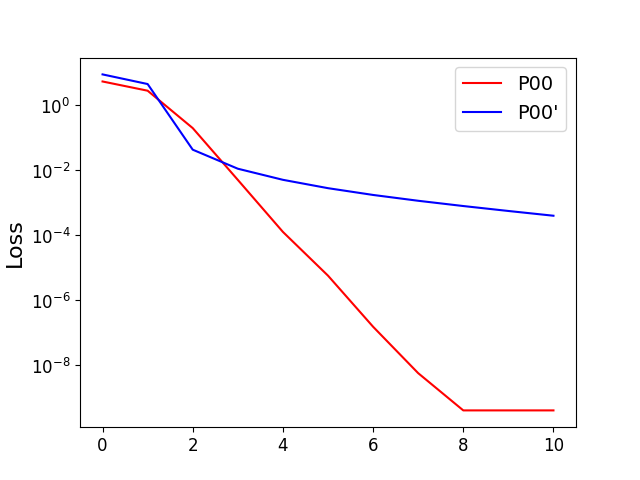

In [45]:
plt.figure()
plt.plot(loss_history_P00, 'r', label="P00")
plt.plot(loss_history_P00prime, 'b', label="P00'")
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()

<IPython.core.display.Javascript object>


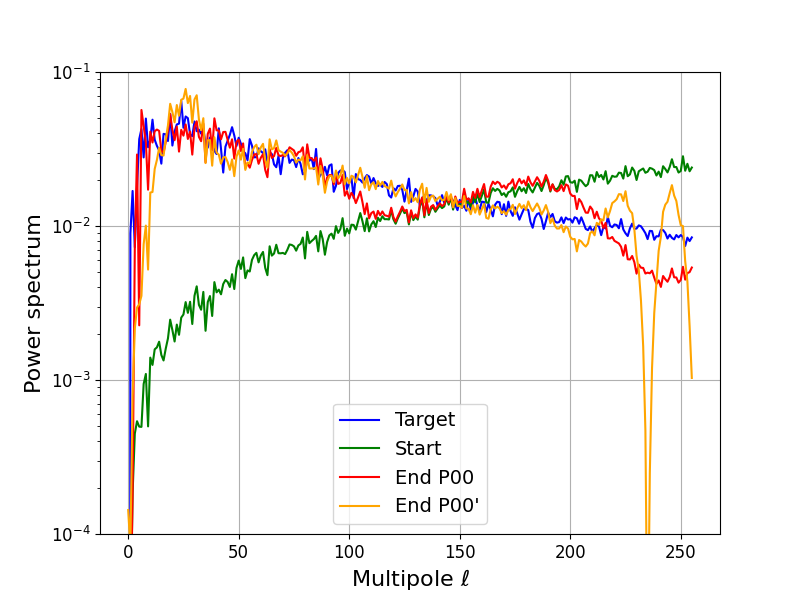

In [46]:
ps_target = sphlib.compute_ps(flm_target)
ps_start = sphlib.compute_ps(flm_start)
ps_end_P00 = sphlib.compute_ps(flm_end_P00)
ps_end_P00prime = sphlib.compute_ps(flm_end_P00prime)

plt.figure(figsize=(8, 6))
plt.plot(ps_target, 'b', label="Target")
plt.plot(ps_start, 'g', label="Start")
plt.plot(ps_end_P00, 'r', label="End P00")
plt.plot(ps_end_P00prime, 'orange', label="End P00'")

plt.yscale("log")
#plt.xscale("log", base=2)
plt.xlabel(r'Multipole $\ell$')
plt.ylabel('Power spectrum')
plt.grid()
#plt.xlim(2, 64)
plt.ylim(1e-4, 1e-1)
plt.legend()